# Fine-tuning a masked language model (TensorFlow)

Install the Transformers and Datasets libraries to run this notebook.

In [ ]:
!pip install datasets transformers[sentencepiece]
!apt install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 7.3 MB/s 
     |████████████████████████████████| 4.4 MB 69.0 MB/s 
     |████████████████████████████████| 212 kB 71.2 MB/s 
     |████████████████████████████████| 1.1 MB 58.6 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 140 kB 74.8 MB/s 
     |████████████████████████████████| 596 kB 64.2 MB/s 
     |████████████████████████████████| 127 kB 73.6 MB/s 
     |████████████████████████████████| 144 kB 73.2 MB/s 
     |████████████████████████████████| 271 kB 74.5 MB/s 
     |████████████████████████████████| 94 kB 733 kB/s 
     |████████████████████████████████| 6.6 MB 48.7 MB/s 
     |████████████████████████████████| 1.2 MB 44.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib

In [ ]:
import numpy as np
import tensorflow as tf

inputs = tokenizer(text, return_tensors="np")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
# We negate the array before argsort to get the largest, not the smallest, logits
top_5_tokens = np.argsort(-mask_token_logits)[:5].tolist()

for token in top_5_tokens:
    print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

def tokenize_function(examples):
  result = tokenizer(examples["text"])
  if tokenizer.is_fast:
      result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
  return result

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

import collections
import numpy as np

# from transformers.data import tf_default_data_collator
from transformers.data.data_collator import tf_default_data_collator
wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id

    return tf_default_data_collator(features)

>>> جدیدترین خبرهای «حضور بانوان در ورزشگاه ها»
>>> جدیدترین خبرهای «حضور زنان در ورزشگاه ها»
>>> جدیدترین خبرهای «حضور ورزشکاران در ورزشگاه ها»
>>> جدیدترین خبرهای «حضور من در ورزشگاه ها»
>>> جدیدترین خبرهای «حضور تماشاگران در ورزشگاه ها»


You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "sajjad_ramezani@ind.iust.ac.ir"
!git config --global user.name "Sajjad"

In [ ]:
import pandas as pd
df = pd.read_csv('khabar.csv')
df = df[df['text'].apply(lambda x : len(x.split())>3)]
df.head()

,text,label
0,ارسال به دیگران پرینت ۱۴۰۰/۰۳/۲۴ ۲۳:۰۵:۱۹ فرآی...,1
1,انصراف زاکانی به سود رئیسی صحت دارد؟ - خبرآنلاین,13
2,جوان ترین ثروتمندان جهان را بشناسید | پایگاه...,2
3,خبرگزاری آریا - طرح ملاقات تصويري زندانيان با ...,1
4,جدیدترین خبرهای «حضور تماشاگران در ورزشگاه ها»...,13


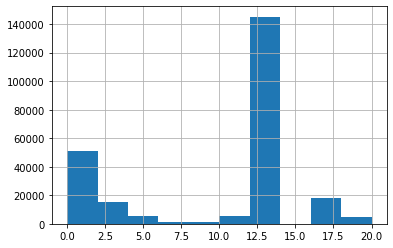

In [ ]:
df['label'].hist()

In [ ]:
labels = list(df['label'].value_counts()[:10].index)

In [ ]:
len_data = df['label'].value_counts()[:10].to_list()

In [ ]:
labels = [0,1,10,12,13,16,19,2,3,5]

In [ ]:
import pandas as pd

In [ ]:
base_path = '/content/drive/MyDrive/NLP/'
l=[]
for la in labels:
    l.append(pd.read_csv(base_path+f'khabar_{la}.csv'))
#   df[df['label']==la].to_csv(base_path+f'khabar_{la}.csv',index=None)

In [ ]:
df = pd.concat(l, axis=0, ignore_index=True)
df.head()

,text,label
0,اولین تصویر از لندرور هیدروژنی +عکس - خبر ثریا,0.0
1,ستاره‌ای که از سفر مرگ پیاده شد پیتزا سفارش دا...,0.0
2,انتقادات تند دبیر کمیته صنعت ستاد حجت الاسلام ...,0.0
3,توقیف پراید با ۱۸۹ کیلو تریاک | خبر روز,0.0
4,پليس راه استان البرز | سایت خبری کرج رسا,0.0


In [ ]:
df = df[~df['label'].isnull().values]

In [ ]:
df['label']

In [ ]:
df['label'] = df['label'].apply(lambda x: int(x))

In [ ]:
df = df[~df['text'].isnull().values]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,3),min_df=100)
X_train_counts = count_vect.fit_transform(df.text)
X_train_counts.shape

(237350, 4977)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tf, df['label'],
                                                    stratify=df['label'], 
                                                    test_size=0.2)

In [ ]:
df.columns

Index(['text', 'label', 'doc_embed'], dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['doc_embed'], df['label'],
                                                    stratify=df['label'], 
                                                    test_size=0.2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight='balanced').fit(np.stack(X_train, axis=0), y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier().fit(X_train, y_train)

In [ ]:
clf.score(X_train,y_train)

0.8523488519064673

In [ ]:
clf.score(X_test,y_test)

0.8419212133979356

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix , plot_confusion_matrix
cm = confusion_matrix(y_test,clf.predict(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


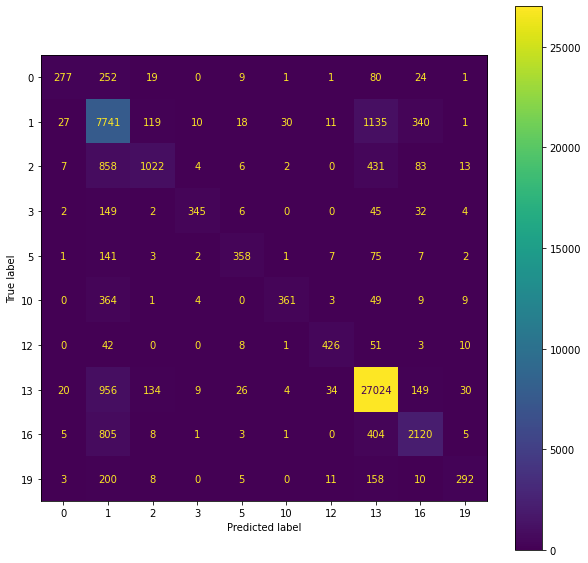

In [ ]:
# plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X_test, y_test,ax=ax)
plt.show() 

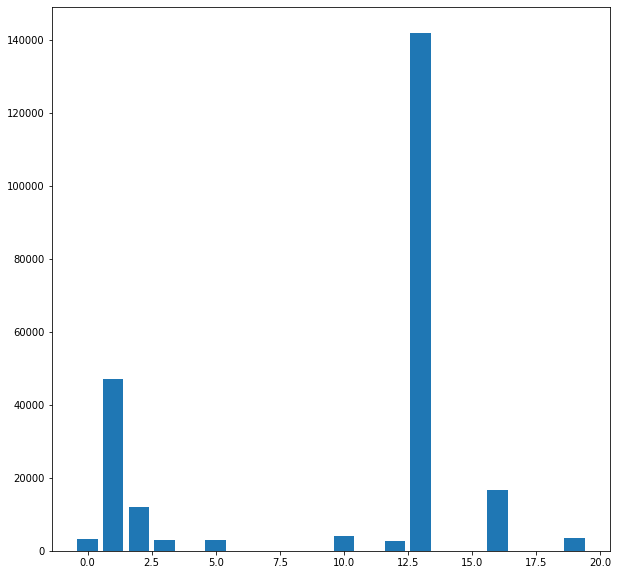

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(df['label'].value_counts().index,df['label'].value_counts().values)
plt.show()

(array([10096.,  3011.,   597.,     0.,     0.,   800., 28927.,     0.,
         3352.,   687.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

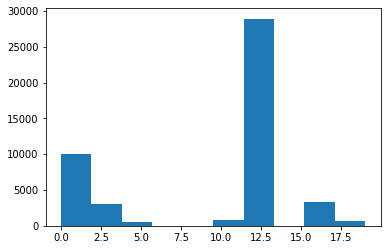

In [ ]:
## RNN

## Word2Vec

In [ ]:
from gensim.test.utils import common_texts

from gensim.models import Word2Vec
model = Word2Vec(sentences=df['text'], size=128, window=5, min_count=1, workers=4)

In [ ]:
model.train(sentences = df['text'], total_words=1000, epochs=100)

(354360601, 1526853300)

In [ ]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 5.1 MB/s 
     |████████████████████████████████| 233 kB 9.7 MB/s 
     |████████████████████████████████| 1.4 MB 28.7 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=58fcabee488a18b976b61ac1461db428f661f9f45c3ca8590290094bb395f51c
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154947 sha256=f1909e1349a28d89437516b2e466781a62b7527a96d2a2e6710a4706b2420d55
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [ ]:
from hazm import word_tokenize

In [ ]:
def embed_doc(r):
  res = np.zeros(128)
  for w in r.split():
    if w in model.wv:
      res+=model.wv[w]
  return res

In [ ]:

df['doc_embed'] = df['text'].apply(embed_doc)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
from keras.utils.np_utils import to_categorical
categorical_labels = to_categorical(df['label'])


In [ ]:
import numpy as np

In [ ]:

# X_train, X_test, y_train, y_test = train_test_split(df['doc_embed'], categorical_labels,
#                                                     stratify=df['label'], 
#                                                     test_size=0.2)

In [ ]:
model_clf = keras.Sequential(
    [
        layers.Dense(128, activation="relu", name="layer1"),
        layers.Dense(64, activation="relu", name="layer2"),
        layers.Dropout(0.2),
        layers.Dense(20,activation='softmax', name="layer3"),
    ]
)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tf, categorical_labels,
                                                    stratify=df['label'], 
                                                    test_size=0.2)

In [ ]:
X_train.shape

(189880, 4977)

In [ ]:

model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model_clf.fit(X_train, y_train,
                    epochs=5,
                    batch_size=128)

Epoch 1/5
1484/1484 [==============================] - 10s 6ms/step - loss: 0.1186 - acc: 0.9587
Epoch 2/5
1484/1484 [==============================] - 7s 5ms/step - loss: 0.1026 - acc: 0.9640
Epoch 3/5
1484/1484 [==============================] - 7s 4ms/step - loss: 0.0906 - acc: 0.9679
Epoch 4/5
1484/1484 [==============================] - 7s 4ms/step - loss: 0.0805 - acc: 0.9718
Epoch 5/5
1484/1484 [==============================] - 7s 4ms/step - loss: 0.0729 - acc: 0.9742


In [ ]:
model_clf.evaluate(X_test,y_test)

1484/1484 [==============================] - 4s 3ms/step - loss: 0.7388 - acc: 0.8802


[0.7388462424278259, 0.8801558613777161]

In [ ]:
y_pred = np.argmax(model_clf.predict(X_test),axis=1)
y_pred.shape

(47470,)

In [ ]:
df['label'].shape

(237350,)

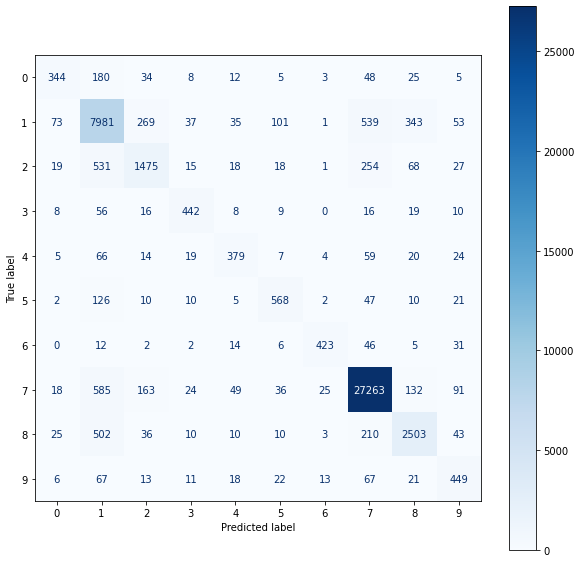

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()


## RNN

In [ ]:
max_features = 4978  # number of words to consider as features
maxlen = 30  # cut texts after this number of words (among top max_features most common words)


In [ ]:
df['seq'] = df['text'].apply(lambda x : list(map(lambda y:count_vect.vocabulary_.get(y,4978),tf.keras.preprocessing.text.text_to_word_sequence(x))))

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(64, return_sequences=True))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          159264    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 64)          6208      
                                                                 
Total params: 165,472
Trainable params: 165,472
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df['seq'][0]

[748, 1303, 378, 4978, 4978, 3226, 1748, 1428]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['seq'], categorical_labels,
                                                    stratify=df['label'], 
                                                    test_size=0.2)

In [ ]:
X_train[0]

[748, 1303, 378, 4978, 4978, 3226, 1748, 1428]

In [ ]:
(input_train, y_train), (input_test, y_test) = (X_train, y_train) ,(X_test, y_test)

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence


# print('Loading data...')
# (input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# print(len(input_train), 'train sequences')
# print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Pad sequences (samples x time)
input_train shape: (189880, 30)
input_test shape: (47470, 30)


In [ ]:
# model = Sequential()
# model.add(Embedding(max_features, 32))
# model.add(layers.LSTM(32,dropout=0.2,return_sequences=True))
# model.add(layers.LSTM(32,dropout=0.2,return_sequences=False))
# model.add(layers.Dense(20, activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.05)

Epoch 1/20
1410/1410 [==============================] - 15s 11ms/step - loss: 0.2815 - acc: 0.9096 - val_loss: 0.3695 - val_acc: 0.8854
Epoch 2/20
1410/1410 [==============================] - 11s 8ms/step - loss: 0.2776 - acc: 0.9116 - val_loss: 0.3683 - val_acc: 0.8843
Epoch 3/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.2752 - acc: 0.9118 - val_loss: 0.3709 - val_acc: 0.8868
Epoch 4/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.2725 - acc: 0.9126 - val_loss: 0.3745 - val_acc: 0.8843
Epoch 5/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.2700 - acc: 0.9137 - val_loss: 0.3754 - val_acc: 0.8852
Epoch 6/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.2681 - acc: 0.9138 - val_loss: 0.3735 - val_acc: 0.8855
Epoch 7/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.2663 - acc: 0.9147 - val_loss: 0.3733 - val_acc: 0.8860
Epoch 8/20
1410/1410 [==============================] 

In [ ]:
input_test.shape

(47470, 30)

In [ ]:
model.evaluate(input_test,y_test)

1484/1484 [==============================] - 6s 4ms/step - loss: 0.3839 - acc: 0.8877


[0.3839445412158966, 0.8877395987510681]

In [ ]:
y_pred = np.argmax(model.predict(input_test),axis=1)
y_pred.shape

(47470,)

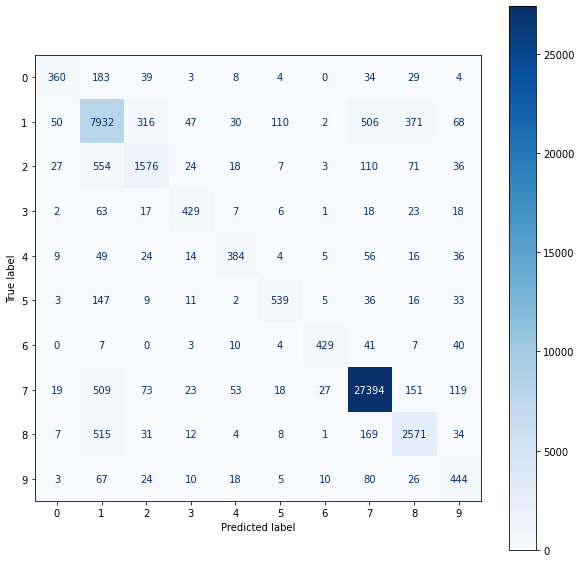

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()


In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          159264    
                                                                 
 lstm_2 (LSTM)               (None, None, 32)          8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 20)                660       
                                                                 
Total params: 176,564
Trainable params: 176,564
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save(base_path+'calssification/LSTM')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/calssification/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/calssification/LSTM/assets


In [ ]:
model_clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 128)               637184    
                                                                 
 layer2 (Dense)              (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 layer3 (Dense)              (None, 20)                1300      
                                                                 
Total params: 646,740
Trainable params: 646,740
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_clf.save(base_path+'calssification/dense')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/calssification/dense/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/calssification/dense/assets


## Transformers

In [ ]:
# Install required packages

!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

     |████████████████████████████████| 4.4 MB 14.0 MB/s 
     |████████████████████████████████| 101 kB 9.1 MB/s 
     |████████████████████████████████| 596 kB 46.9 MB/s 
     |████████████████████████████████| 6.6 MB 42.1 MB/s 
     |████████████████████████████████| 316 kB 29.2 MB/s 
     |████████████████████████████████| 233 kB 30.9 MB/s 
     |████████████████████████████████| 1.4 MB 61.1 MB/s 
     |████████████████████████████████| 175 kB 39.9 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 235 kB 65.1 MB/s 


In [ ]:
# Import required packages

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

# import plotly.express as px
# import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
data = df.copy()

In [ ]:
import re
minlim, maxlim = 3, 256

In [ ]:
# cleaning comments
data['cleaned_comment'] = data['text'].apply(cleaning)


# calculate the length of comments based on their words
data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# remove comments with the length of fewer than three words
data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
data = data.dropna(subset=['cleaned_comment_len_by_words'])
data = data.reset_index(drop=True)

data.head()

,text,label,seq,cleaned_comment,cleaned_comment_len_by_words
0,اولین تصویر از لندرور هیدروژنی +عکس - خبر ثریا,0,"[748, 1303, 378, 4978, 4978, 3226, 1748, 1428]",اولین تصویر از لندرور هیدروژنی +عکس - خبر ثریا,9
1,ستاره‌ای که از سفر مرگ پیاده شد پیتزا سفارش دا...,0,"[4978, 4762, 378, 2774, 3701, 4515, 2898, 4978...",ستاره‌ای که از سفر مرگ پیاده شد پیتزا سفارش دا...,13
2,انتقادات تند دبیر کمیته صنعت ستاد حجت الاسلام ...,0,"[4978, 1342, 2164, 4732, 3095, 2722, 1654, 602...",انتقادات تند دبیر کمیته صنعت ستاد حجت الاسلام ...,55
3,توقیف پراید با ۱۸۹ کیلو تریاک | خبر روز,0,"[1374, 4430, 820, 4978, 4788, 1266, 1748, 2568]",توقیف پراید با ۱۸۹ کیلو تریاک | خبر روز,9
4,پليس راه استان البرز | سایت خبری کرج رسا,0,"[4978, 2476, 452, 604, 2710, 1937, 4642, 4978]",پلیس راه استان البرز | سایت خبری کرج رسا,9


In [ ]:
data[['text','cleaned_comment']].to_csv(base_path+'khabar_cleaned.csv')

In [ ]:
data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,اولین تصویر از لندرور هیدروژنی +عکس - خبر ثریا,0
1,ستاره‌ای که از سفر مرگ پیاده شد پیتزا سفارش دا...,0
2,انتقادات تند دبیر کمیته صنعت ستاد حجت الاسلام ...,0
3,توقیف پراید با ۱۸۹ کیلو تریاک | خبر روز,0
4,پلیس راه استان البرز | سایت خبری کرج رسا,0


In [ ]:
labels

[0, 1, 10, 12, 13, 16, 19, 2, 3, 5]

In [ ]:
data['label_id'] = data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(data, test_size=0.2, random_state=1, stratify=data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(170892, 3)
(18988, 3)
(47470, 3)


In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for ra,la in enumerate(labels[6:]):
  try:
    from transformers import TFAutoModelForMaskedLM

    model_checkpoint = "HooshvareLab/bert-fa-base-uncased"
    model = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint)
    model(model.dummy_inputs)  # Build the model
    # model.summary()
    from transformers import AutoTokenizer

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    from datasets import load_dataset

    imdb_dataset = load_dataset('csv',column_names=['text', 'label'],data_files ={'train': base_path+f"khabar_{la}.csv",'test':'/content/sample_khabar.csv'})
    # imdb_dataset = load_dataset('imdb')

    # Use batched=True to activate fast multithreading!
    tokenized_datasets = imdb_dataset.map(
        tokenize_function, batched=True, remove_columns=["text", "label"]
    )
    chunk_size = 128


    lm_datasets = tokenized_datasets.map(group_texts, batched=True)

    from transformers import DataCollatorForLanguageModeling

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

    train_size = 0.99
    test_size = 0.01

    downsampled_dataset = lm_datasets["train"].train_test_split(
        train_size=train_size, test_size=test_size, seed=42
    )
    tf_train_dataset = downsampled_dataset["train"].to_tf_dataset(
        columns=["input_ids", "attention_mask", "labels"],
        collate_fn=data_collator,
        shuffle=True,
        batch_size=32,
    )

    tf_eval_dataset = downsampled_dataset["test"].to_tf_dataset(
        columns=["input_ids", "attention_mask", "labels"],
        collate_fn=data_collator,
        shuffle=False,
        batch_size=32,
    )

    from transformers import create_optimizer
    from transformers.keras_callbacks import PushToHubCallback
    import tensorflow as tf

    num_train_steps = len(tf_train_dataset)
    optimizer, schedule = create_optimizer(
        init_lr=2e-5,
        num_warmup_steps=1_000,
        num_train_steps=num_train_steps,
        weight_decay_rate=0.01,
    )
    model.compile(optimizer=optimizer)

    # Train in mixed-precision float16
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

    # callback = PushToHubCallback(
    #     output_dir=f"{model_name}-finetuned-imdb", tokenizer=tokenizer
    # )

    import math

    eval_loss = model.evaluate(tf_eval_dataset)
    print(f"Perplexity: {math.exp(eval_loss):.2f}")

    model.fit(tf_train_dataset, validation_data=tf_eval_dataset,epochs=5)

    eval_loss = model.evaluate(tf_eval_dataset)
    print(f"Perplexity: {math.exp(eval_loss):.2f}")

    ts = ['فرآیند کاهش آمارهای کرونا در تهران [MASK] است',
          'انصراف [MASK] به سود رئیسی صحت دارد',
          'جدیدترین خبرهای «حضور [MASK] در ورزشگاه ها»',
          'دوست جون ها شماها چه جوری خبر [MASK] به شوهرتون دادید',
          'کدام ستاره ها بالاترین [MASK] را دارند']
    for text in ts:
      inputs = tokenizer(text, return_tensors="np")
      token_logits = model(**inputs).logits
      # Find the location of [MASK] and extract its logits
      mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
      mask_token_logits = token_logits[0, mask_token_index, :]
      # Pick the [MASK] candidates with the highest logits
      # We negate the array before argsort to get the largest, not the smallest, logits
      top_5_tokens = np.argsort(-mask_token_logits)[:5].tolist()
      print(text)
      for token in top_5_tokens:
          print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

    model.save(base_path+f'models/model_khabar_online_{la}.md')
  except:
    continue


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-9a82678b150e3416/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1/1 [==============================] - 3s 3s/step - loss: 3.2422
Perplexity: 25.59
Epoch 1/5
14/14 [==============================] - 29s 463ms/step - loss: 3.9167 - val_loss: 3.6582
Epoch 2/5
14/14 [==============================] - 7s 464ms/step - loss: 3.8053 - val_loss: 3.7305
Epoch 3/5
14/14 [==============================] - 7s 466ms/step - loss: 3.6882 - val_loss: 4.5664
Epoch 4/5
14/14 [==============================] - 7s 468ms/step - loss: 3.5887 - val_loss: 2.9980
Epoch 5/5
1/1 [==============================] - 0s 77ms/step - loss: 3.1367
Perplexity: 23.03
فرآیند کاهش آمارهای کرونا در تهران [MASK] است
>>> فرآیند کاهش آمارهای کرونا در تهران زمانبر است
>>> فرآیند کاهش آمارهای کرونا در تهران تدریجی است
>>> فرآیند کاهش آمارهای کرونا در تهران چگونه است
>>> فرآیند کاهش آمارهای کرونا در تهران ضروری است
>>> فرآیند کاهش آمارهای کرونا در تهران متفاوت است
انصراف [MASK] به سود رئیسی صحت دارد
>>> انصراف قالیباف به سود رئیسی صحت دارد
>>> انصراف بقایی به سود رئیسی صحت دارد
>>> انصراف میرس

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_0.md/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_0.md/assets
All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c8426901c5362101/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1/1 [==============================] - 3s 3s/step - loss: 4.7617
Perplexity: 116.95
Epoch 1/5
14/14 [==============================] - 29s 462ms/step - loss: 4.5252 - val_loss: 4.2656
Epoch 2/5
14/14 [==============================] - 7s 464ms/step - loss: 4.5552 - val_loss: 5.0312
Epoch 3/5
14/14 [==============================] - 7s 464ms/step - loss: 4.4215 - val_loss: 4.1211
Epoch 4/5
14/14 [==============================] - 7s 468ms/step - loss: 4.3186 - val_loss: 4.7852
Epoch 5/5
1/1 [==============================] - 0s 76ms/step - loss: 2.7285
Perplexity: 15.31
فرآیند کاهش آمارهای کرونا در تهران [MASK] است
>>> فرآیند کاهش آمارهای کرونا در تهران زمانبر است
>>> فرآیند کاهش آمارهای کرونا در تهران تدریجی است
>>> فرآیند کاهش آمارهای کرونا در تهران چگونه است
>>> فرآیند کاهش آمارهای کرونا در تهران ضروری است
>>> فرآیند کاهش آمارهای کرونا در تهران متفاوت است
انصراف [MASK] به سود رئیسی صحت دارد
>>> انصراف قالیباف به سود رئیسی صحت دارد
>>> انصراف بقایی به سود رئیسی صحت دارد
>>> انصراف میر

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_5.md/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_5.md/assets
All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-74115c81f367c69c/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1/1 [==============================] - 6s 6s/step - loss: 2.7852
Perplexity: 16.20
Epoch 1/5
26/26 [==============================] - 34s 484ms/step - loss: 2.8008 - val_loss: 2.2285
Epoch 2/5
26/26 [==============================] - 13s 485ms/step - loss: 2.8211 - val_loss: 2.5078
Epoch 3/5
26/26 [==============================] - 13s 491ms/step - loss: 2.7614 - val_loss: 1.8115
Epoch 4/5
26/26 [==============================] - 13s 493ms/step - loss: 2.6237 - val_loss: 2.2871
Epoch 5/5
1/1 [==============================] - 0s 93ms/step - loss: 2.0625
Perplexity: 7.87
فرآیند کاهش آمارهای کرونا در تهران [MASK] است
>>> فرآیند کاهش آمارهای کرونا در تهران چگونه است
>>> فرآیند کاهش آمارهای کرونا در تهران زمانبر است
>>> فرآیند کاهش آمارهای کرونا در تهران تدریجی است
>>> فرآیند کاهش آمارهای کرونا در تهران ضروری است
>>> فرآیند کاهش آمارهای کرونا در تهران چقدر است
انصراف [MASK] به سود رئیسی صحت دارد
>>> انصراف قالیباف به سود رئیسی صحت دارد
>>> انصراف میرسلیم به سود رئیسی صحت دارد
>>> انصراف بق

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_3.md/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_3.md/assets
All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-40c26a43d079d10d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1/1 [==============================] - 3s 3s/step - loss: 4.6133
Perplexity: 100.81
Epoch 1/5
11/11 [==============================] - 25s 491ms/step - loss: 5.4664 - val_loss: 5.0000
Epoch 2/5
11/11 [==============================] - 6s 499ms/step - loss: 5.4059 - val_loss: 4.2031
Epoch 3/5
11/11 [==============================] - 5s 489ms/step - loss: 5.3682 - val_loss: 5.9766
Epoch 4/5
11/11 [==============================] - 5s 495ms/step - loss: 5.2538 - val_loss: 5.4180
Epoch 5/5
1/1 [==============================] - 0s 72ms/step - loss: 5.8672
Perplexity: 353.25
فرآیند کاهش آمارهای کرونا در تهران [MASK] است
>>> فرآیند کاهش آمارهای کرونا در تهران زمانبر است
>>> فرآیند کاهش آمارهای کرونا در تهران تدریجی است
>>> فرآیند کاهش آمارهای کرونا در تهران چگونه است
>>> فرآیند کاهش آمارهای کرونا در تهران ضروری است
>>> فرآیند کاهش آمارهای کرونا در تهران متفاوت است
انصراف [MASK] به سود رئیسی صحت دارد
>>> انصراف قالیباف به سود رئیسی صحت دارد
>>> انصراف بقایی به سود رئیسی صحت دارد
>>> انصراف می

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_12.md/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP/models/model_khabar_online_12.md/assets


In [ ]:
141931 /128

1108.8359375

In [ ]:
imdb_dataset.data['train'][0]

[
  [
    "text",
    "انصراف زاکانی به سود رئیسی صحت دارد؟ - خبرآنلاین",
    "جدیدترین خبرهای «حضور تماشاگران در ورزشگاه ها»  - خبربان",
    "جدیدترین خبرهای «منطقه مشیریه»  - خبربان",
    "آخرین اخبار «نفر تایید شدند»  - ۶ - خبربان",
    "کدام ستاره ها بالاترین آی کیو را دارند؟ | خبرگزاری شیعیان افغانستان | Afghanistan - Shia News Agency",
    "جدیدترین خبرهای «نتایج آزمون استخدام»  - خبربان",
    "جدیدترین خبرهای «بيمه قالي بافي»  - خبربان",
    "خبرگزاری آریا - موفقيت «نام من فرانچسکو توتي است» در جشنواره روتردام",
    "آموزش سرمایه گذاری در مسکن و طلا توسط مستر تریدر - خبرگزاری برنا",
    ...
    "جدیدترین خبرهای «قیمت خودرو شاهین سایپا»  - خبربان",
    "مهاجرت و پناهندگی؛ قصه متفاوت توکیو 2020 - خبرآنلاین",
    "جدیدترین خبرهای «بازی های دوستانه ملی»  - خبربان",
    "جدیدترین خبرهای «نتیجه بازی سپاهان پرسپولیس»  - خبربان",
    "آخرین اخبار «سرپرست جدید آموزش و پرورش»  - خبربان",
    "جدیدترین خبرهای «صندلی ایستاده»  - خبربان",
    "جدیدترین خبرهای «فرمانداری ری»  - خبربان",
    "

In [ ]:
model_name='ss'

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1/1 [==============================] - 8s 8s/step - loss: 3.4144
Perplexity: 30.40


Epoch 1/5
313/313 [==============================] - 451s 1s/step - loss: 2.2263 - val_loss: 2.1412
Epoch 2/5
313/313 [==============================] - 455s 1s/step - loss: 2.2296 - val_loss: 2.0752
Epoch 3/5
313/313 [==============================] - 455s 1s/step - loss: 2.2173 - val_loss: 2.2105
Epoch 4/5
313/313 [==============================] - 455s 1s/step - loss: 2.2064 - val_loss: 2.1000
Epoch 5/5
313/313 [==============================] - 456s 1s/step - loss: 2.2127 - val_loss: 2.1414


4/4 [==============================] - 2s 340ms/step - loss: 2.1787
Perplexity: 8.83


In [ ]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="huggingface-course/distilbert-base-uncased-finetuned-imdb"
)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['sequence']}")

>>> بابا ابي.
>>> بابا ابه.
>>> بابا ابد.
>>> بابا ابا.
>>> بابا ابو.


In [ ]:
model.save("model_khabar_online.md")

INFO:tensorflow:Assets written to: model_khabar_online.md/assets


INFO:tensorflow:Assets written to: model_khabar_online.md/assets


In [ ]:
text = "بابا اب  [MASK]."

In [ ]:
import pandas as pd
df = pd.read_csv('/content/sample_khabar.csv')

In [ ]:
 for r in df['text'].iloc[:10]:
   print(r)

ارسال به دیگران پرینت ۱۴۰۰/۰۳/۲۴ ۲۳:۰۵:۱۹ فرآیند کاهش آمارهای کرونا در تهران کند است تهران- فرمانده ستاد مقابله با کرونا در تهران از کاهش ۱۷.۵ درصدی جانباختگان بر اثر کرونا در پایتخت خبر داد و گفت: فرآیند کاهش آمارهای کرونا در تهران کند است.
انصراف زاکانی به سود رئیسی صحت دارد؟ - خبرآنلاین
  جوان ترین ثروتمندان جهان را بشناسید | پایگاه خبری تحلیلی عصر گیلان
خبرگزاری آریا - طرح ملاقات تصويري زندانيان با خانواده‌‎هايشان عملياتي شد
جدیدترین خبرهای «حضور تماشاگران در ورزشگاه ها»  - خبربان
دوست جون ها شماها چه جوری خبر بارداریتونو به شوهرتون دادید؟
جدیدترین خبرهای «منطقه مشیریه»  - خبربان
آخرین اخبار «نفر تایید شدند»  - ۶ - خبربان
کدام ستاره ها بالاترین آی کیو را دارند؟ | خبرگزاری شیعیان افغانستان | Afghanistan - Shia News Agency
جدیدترین خبرهای «نتایج آزمون استخدام»  - خبربان


In [ ]:
ts = ['فرآیند کاهش آمارهای کرونا در تهران [MASK] است',
      'انصراف [MASK] به سود رئیسی صحت دارد',
      'جدیدترین خبرهای «حضور [MASK] در ورزشگاه ها»',
      'دوست جون ها شماها چه جوری خبر [MASK] به شوهرتون دادید',
      'کدام ستاره ها بالاترین [MASK] را دارند']
for text in ts:
  inputs = tokenizer(text, return_tensors="np")
  token_logits = model(**inputs).logits
  # Find the location of [MASK] and extract its logits
  mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
  mask_token_logits = token_logits[0, mask_token_index, :]
  # Pick the [MASK] candidates with the highest logits
  # We negate the array before argsort to get the largest, not the smallest, logits
  top_5_tokens = np.argsort(-mask_token_logits)[:5].tolist()
  print(text)
  for token in top_5_tokens:
      print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

In [ ]:
!zip model.zip -r /content/model_khabar_online.md 

  adding: content/model_khabar_online.md/ (stored 0%)
  adding: content/model_khabar_online.md/variables/ (stored 0%)
  adding: content/model_khabar_online.md/variables/variables.index (deflated 81%)
  adding: content/model_khabar_online.md/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_khabar_online.md/saved_model.pb (deflated 92%)
  adding: content/model_khabar_online.md/assets/ (stored 0%)
  adding: content/model_khabar_online.md/keras_metadata.pb (deflated 95%)
